<a href="https://colab.research.google.com/github/devadharshini-162/Pulsar-Detection/blob/main/Synthetic_dataset_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization

In [ ]:
data_url = "HTRU_2.csv"
columns = ["Mean_IP", "Std_IP", "Kurt_IP", "Skew_IP", "Mean_DM", "Std_DM", "Kurt_DM", "Skew_DM", "Class"]
df = pd.read_csv(data_url, header=None, names=columns)

In [ ]:
X = df.drop("Class", axis=1).values  # Features
y = df["Class"].values  # Labels
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_pulsar = X_scaled[y == 1]

In [ ]:
latent_dim = 100
data_dim = X_pulsar.shape[1]

In [ ]:
def build_generator(latent_dim, data_dim):
  model = Sequential([
        Dense(64, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Dense(data_dim, activation='tanh')
    ])
  return model

In [ ]:
def build_discriminator(data_dim):
    def minibatch_discrimination(x):
        diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 0, 2]), 0)
        abs_diffs = K.sum(K.abs(diffs), 2)
        minibatch_features = K.sum(K.exp(-abs_diffs), 2)
        return K.concatenate([x, minibatch_features], axis=2)
    model = Sequential([
        Dense(128, input_dim=data_dim),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.trainable = False

gan = Sequential([generator, discriminator])
gan.compile(optimizer='adam', loss='binary_crossentropy')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
epochs = 5000
batch_size = 16
real_labels = np.random.uniform(0.9, 1.0, (batch_size, 1))  # Smooth positive labels
fake_labels = np.random.uniform(0.0, 0.1, (batch_size, 1))  # Smooth negative labels

In [ ]:
for epoch in range(0, epochs, 10000):
    # Train Discriminator
    idx = np.random.randint(0, X_pulsar.shape[0], batch_size)
    real_data = X_pulsar[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average the two losses

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    # Print Progress
    if epoch % 1000 == 0:
      generator.save(f"generator_epoch_{epoch}.h5")
      discriminator.save(f"discriminator_epoch_{epoch}.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
noise = np.random.normal(0, 1, (1000, latent_dim))
synthetic_data = generator.predict(noise)
synthetic_data = scaler.inverse_transform(synthetic_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns[:-1])
synthetic_df.to_csv("synthetic_pulsar_data.csv", index=False)
print("Synthetic pulsar data generated and saved to 'synthetic_pulsar_data.csv'.")

Synthetic pulsar data generated and saved to 'synthetic_pulsar_data.csv'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
synthetic_df.to_csv('/content/drive/My Drive/synthetic_pulsar_data.csv', index=False)

# Visualization 2

In [ ]:
df_real_pulsars = df[df["Class"] == 1]

In [ ]:
df_synthetic_pulsars = synthetic_df  # Assuming synthetic data already represents only pulsars


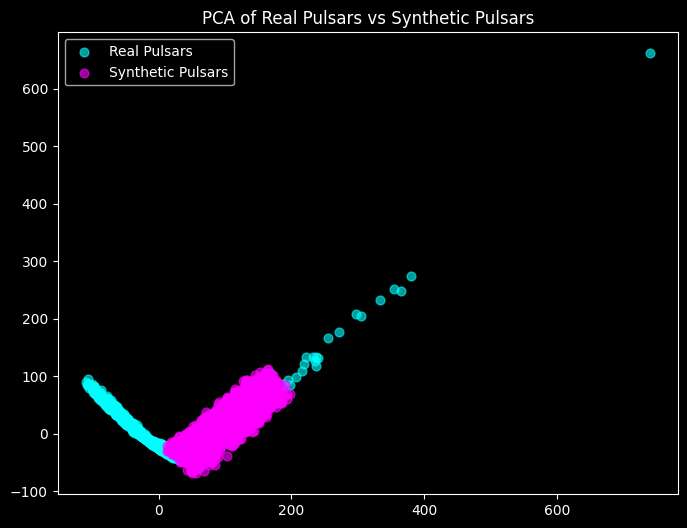

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant features (excluding class labels)
X_real_pulsars = df_real_pulsars.drop(columns=["Class"])
X_synthetic = df_synthetic_pulsars.drop(columns=["Class"], errors="ignore")  # Ignore if class column is absent

# Apply PCA (reduce to 2D for visualization)
pca = PCA(n_components=2)
X_real_pulsars_pca = pca.fit_transform(X_real_pulsars)
X_synthetic_pulsars_pca = pca.transform(X_synthetic)

#sns.style("whitegrid")
plt.style.use("dark_background")
# Plot the new PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_real_pulsars_pca[:, 0], X_real_pulsars_pca[:, 1], color='#00FFFF', label="Real Pulsars", alpha=0.6 , s=40)
plt.scatter(X_synthetic_pulsars_pca[:, 0], X_synthetic_pulsars_pca[:, 1], color='#FF00FF', label="Synthetic Pulsars", alpha=0.6 , s=40)
plt.legend()
plt.title("PCA of Real Pulsars vs Synthetic Pulsars")
plt.show()


In [ ]:
print(pca.explained_variance_ratio_)


[0.6105539  0.24984241]


In [ ]:
pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=d667756bbbf17603f3b63e015aef5d204a1a3526718ebe22f3d2202054ebb5d9
  Stored in directory: /root/.cache/pip/wheels/82/d8/73/e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap


In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00


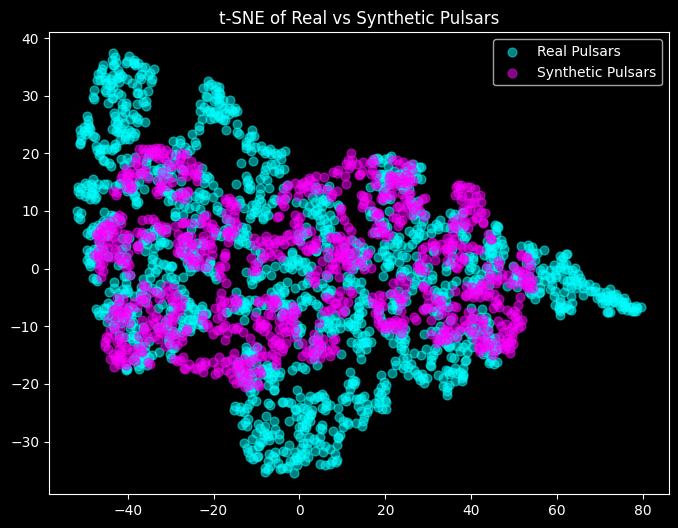

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
real_tsne = tsne.fit_transform(X_real_pulsars)
synthetic_tsne = tsne.fit_transform(X_synthetic)



# Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(real_tsne[:, 0], real_tsne[:, 1], color='#00FFFF', label='Real Pulsars', alpha=0.5, s=40)
plt.scatter(synthetic_tsne[:, 0], synthetic_tsne[:, 1], color='#FF00FF', label='Synthetic Pulsars', alpha=0.5, s=40)
plt.title('t-SNE of Real vs Synthetic Pulsars')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


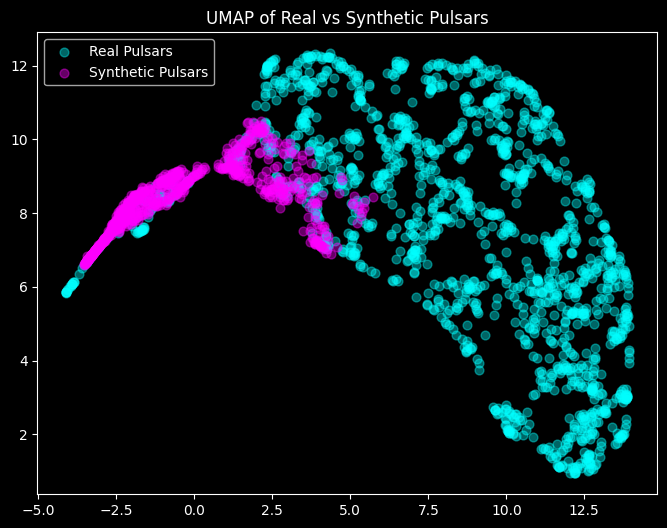

In [ ]:
import umap.umap_ as um
# Run UMAP
umap_model = um.UMAP(n_components=2, n_neighbors=15, random_state=42)
real_umap = umap_model.fit_transform(X_real_pulsars)
synthetic_umap = umap_model.transform(X_synthetic)

# Plot UMAP
plt.figure(figsize=(8, 6))
plt.scatter(real_umap[:, 0], real_umap[:, 1], color='#00FFFF', label='Real Pulsars', alpha=0.4, s=40)
plt.scatter(synthetic_umap[:, 0], synthetic_umap[:, 1], color='#FF00FF', label='Synthetic Pulsars', alpha=0.4, s=40)
plt.title('UMAP of Real vs Synthetic Pulsars')
plt.legend()
plt.show()


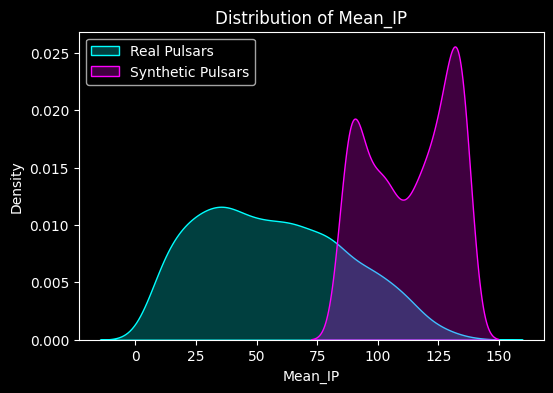

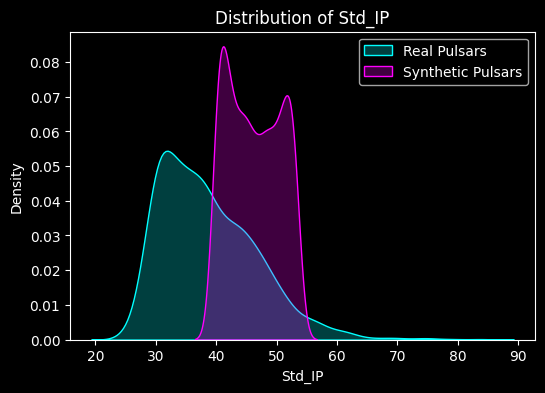

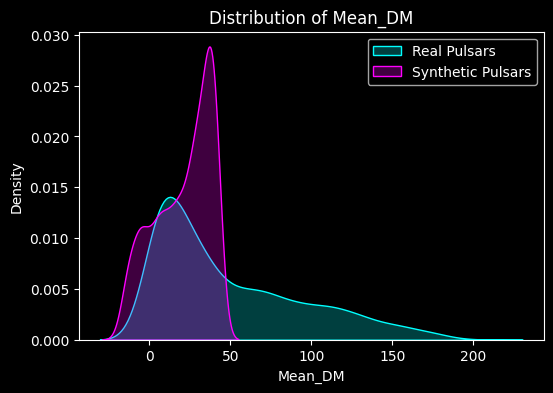

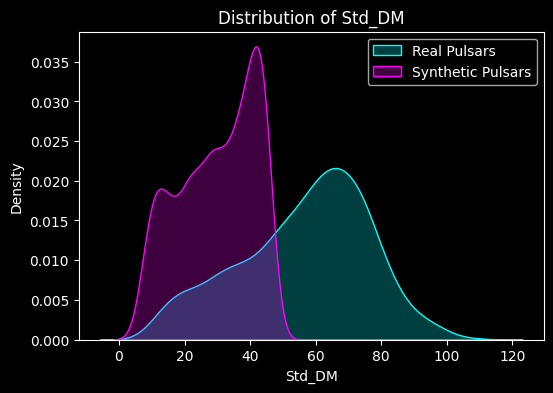

In [ ]:
# Select a few important features for comparison
features = ['Mean_IP', 'Std_IP', 'Mean_DM', 'Std_DM']  # Replace with actual feature names

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df_real_pulsars[feature], color='#00FFFF', label='Real Pulsars', fill=True)
    sns.kdeplot(df_synthetic_pulsars[feature], color='#FF00FF', label='Synthetic Pulsars', fill=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()
